In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib
import numpy as np
import pandas as pd

In [3]:
DATA_DIR = pathlib.Path("data")

# Data description

Data contains reading from IoT devices with indication of if it was broken or not.

# Loading data

In [4]:
orig_features = pd.read_csv(DATA_DIR / "maintenance.txt", delimiter=";")

In [5]:
orig_features.head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1


Text(0, 0.5, '# of events')

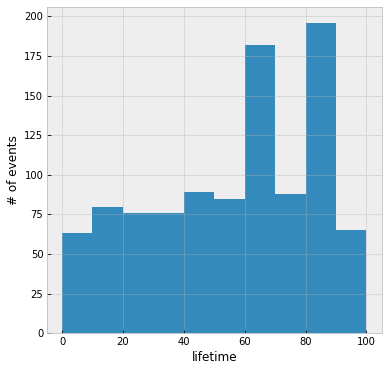

In [6]:
plt.figure(figsize=(6,6))
orig_features.lifetime.plot(kind="hist", range=(0, 100), bins=10)
plt.xlabel("lifetime")
plt.ylabel("# of events")

# Basic test

In [7]:
import lifelines
from lifelines.plotting import qq_plot

In [8]:
model_wb_all = lifelines.WeibullFitter()
model_exp_all = lifelines.ExponentialFitter()
model_ln_all = lifelines.LogNormalFitter()
model_ll_all = lifelines.LogLogisticFitter()

model_wb_all.fit(durations=orig_features["lifetime"], event_observed=orig_features["broken"])
model_exp_all.fit(durations=orig_features["lifetime"], event_observed=orig_features["broken"])
model_ln_all.fit(durations=orig_features["lifetime"], event_observed=orig_features["broken"])
model_ll_all.fit(durations=orig_features["lifetime"], event_observed=orig_features["broken"])

<lifelines.LogLogisticFitter:"LogLogistic_estimate", fitted with 1000 total observations, 603 right-censored observations>

In [9]:
model_wb_all.print_summary()

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 1000 total observations, 603 right-censored observations>
   number of observations = 1000
number of events observed = 397
           log-likelihood = -1544.63
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%      z      p   -log2(p)
lambda_  84.11       0.45            83.23            84.98 185.76 <0.005        inf
rho_      9.54       0.36             8.84            10.25  23.63 <0.005     407.83
---
AIC = 3093.26

In [10]:
model_exp_all.print_summary()

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 1000 total observations, 603 right-censored observations>
   number of observations = 1000
number of events observed = 397
           log-likelihood = -2356.07
               hypothesis = lambda_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%     z      p   -log2(p)
lambda_ 139.03       6.98           125.35           152.71 19.78 <0.005     286.91
---
AIC = 4714.14

In [11]:
model_ll_all.print_summary()

<lifelines.LogLogisticFitter:"LogLogistic_estimate", fitted with 1000 total observations, 603 right-censored observations>
   number of observations = 1000
number of events observed = 397
           log-likelihood = -1579.53
               hypothesis = alpha_ != 1, beta_ != 1

---
         coef   se(coef)   coef lower 95%   coef upper 95%      z      p   -log2(p)
alpha_  80.01       0.54            78.95            81.08 145.28 <0.005        inf
beta_   12.16       0.48            11.22            13.10  23.23 <0.005     394.11
---
AIC = 3163.06

In [12]:
model_ln_all.print_summary()

<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 1000 total observations, 603 right-censored observations>
   number of observations = 1000
number of events observed = 397
           log-likelihood = -1567.54
               hypothesis = mu_ != 0, sigma_ != 1

---
         coef   se(coef)   coef lower 95%   coef upper 95%       z      p   -log2(p)
mu_      4.37       0.01             4.36             4.38  659.00 <0.005        inf
sigma_   0.14       0.00             0.13             0.15 -178.93 <0.005        inf
---
AIC = 3139.09

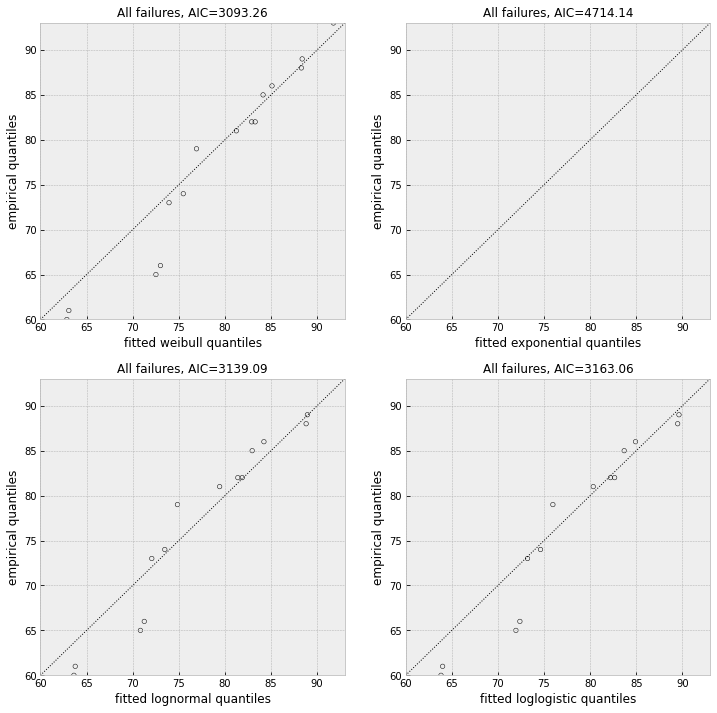

In [13]:
plt.figure(figsize=(12,12))

for i, (model_name, model) in enumerate(zip(["Weibull", "exponential", "log-normal", "log-logistic"],
                                            [model_wb_all, model_exp_all, model_ln_all, model_ll_all])):
    plt.subplot(2,2,i+1)
    qq_plot(model, label="Weibull", ax=plt.gca())
    plt.title(f"All failures, AIC={model.AIC_:.2f}", fontsize=12)
plt.show()

Text(0, 0.5, 'PDF')

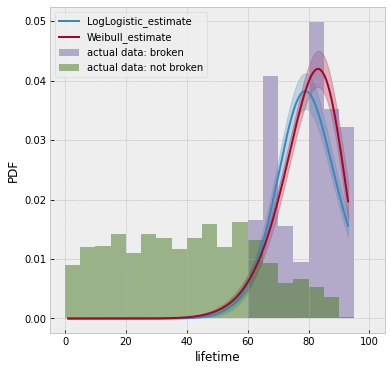

In [14]:
plt.figure(figsize=(6,6))


model_ll_all.plot_density()
model_wb_all.plot_density()
orig_features.loc[orig_features.broken==1, "lifetime"].plot(kind="hist", density=True, range=(0, 100), bins=20,
                                                            label="actual data: broken", alpha=0.5, legend=True)
orig_features.loc[orig_features.broken==0, "lifetime"].plot(kind="hist", density=True, range=(0, 100), bins=20,
                                                            label="actual data: not broken", alpha=0.5, legend=True)

plt.xlabel("lifetime")
plt.ylabel("PDF")

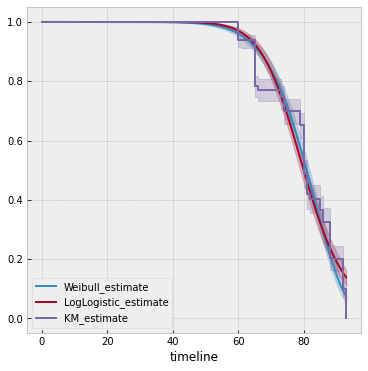

In [15]:
kmf_all = lifelines.KaplanMeierFitter()
kmf_all.fit(durations=orig_features.lifetime, event_observed=orig_features.broken)

plt.figure(figsize=(6,6))
model_wb_all.plot_survival_function()
model_ll_all.plot_survival_function()
kmf_all.plot_survival_function()

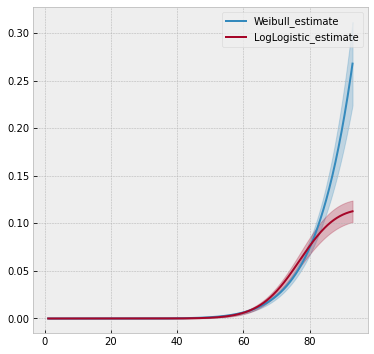

In [16]:
plt.figure(figsize=(6,6))

model_wb_all.plot_hazard()
model_ll_all.plot_hazard()

# Cox proportional hazards model

In [17]:
NUM_FTS = ['pressureInd', 'moistureInd', 'temperatureInd']

features = orig_features.copy()
features[NUM_FTS] = (features[NUM_FTS] - features[NUM_FTS].mean()) / features[NUM_FTS].std()

In [18]:
features = pd.get_dummies(features, columns=["team", "provider"])

## Model

In [19]:
model_cph = lifelines.CoxPHFitter(penalizer=0.1)
model_cph.fit(features, duration_col="lifetime", event_col="broken")

<lifelines.CoxPHFitter: fitted with 1000 total observations, 603 right-censored observations>

In [20]:
model_cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1000 total observations, 603 right-censored observations>
             duration col = 'lifetime'
                event col = 'broken'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 397
   partial log-likelihood = -1722.32
         time fit was run = 2021-03-08 12:54:53 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
pressureInd          0.01       1.01       0.05            -0.08             0.10                 0.93                 1.10
moistureInd         -0.04       0.96       0.05            -0.13             0.05                 0.88                 1.05
temperatureInd       0.15       1.16       0.05             0.06             0.24                 1.06                 1.27
team_TeamA          -0.41       0.66       0.14            -0.69            -0.14                 0.50                 0.87
team_TeamB          -0.41       0.66       0.14            -0.68            -0.14                 0.51                 0.87
team_TeamC           0.87       2.39       0.15             0.58             1.16                 1.79                 3.19
provider_Provider1   0.67       1.95       0.15             0.37             0.97                 1.45                 2.63
provider_Provider2  -2.12       0.12       0.16            -2.44            -1.81                 0.09                 0.16
provider_Provider3   2.70      14.88       0.18             2.35             3.05                10.52                21.04
provider_Provider4  -1.14       0.32       0.15            -1.44            -0.84                 0.24                 0.43

                        z      p   -log2(p)
covariate                                  
pressureInd          0.24   0.81       0.31
moistureInd         -0.90   0.37       1.44
temperatureInd       3.23 <0.005       9.68
team_TeamA          -2.94 <0.005       8.24
team_TeamB          -2.94 <0.005       8.24
team_TeamC           5.92 <0.005      28.17
provider_Provider1   4.44 <0.005      16.74
provider_Provider2 -13.22 <0.005     130.13
provider_Provider3  15.26 <0.005     172.13
provider_Provider4  -7.47 <0.005      43.49
---
Concordance = 1.00
Partial AIC = 3464.64
log-likelihood ratio test = 631.91 on 10 df
-log2(p) of ll-ratio test = 427.18

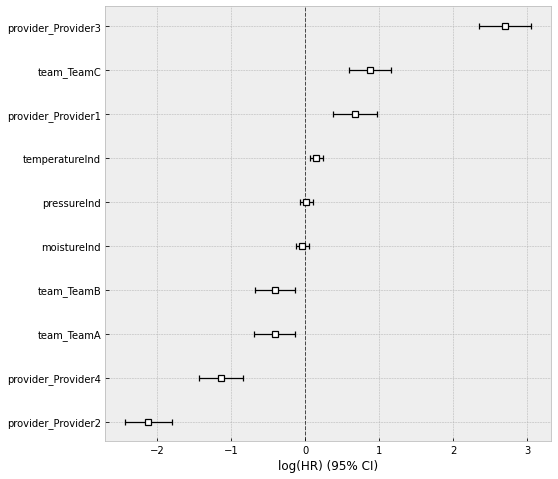

In [21]:
plt.figure(figsize=(8,8))
model_cph.plot()

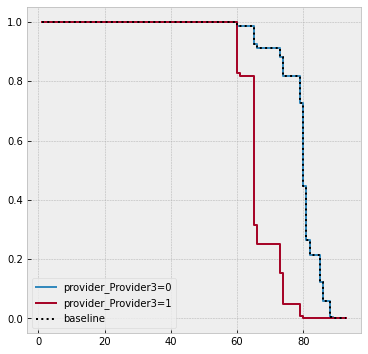

In [22]:
plt.figure(figsize=(6,6))

model_cph.plot_partial_effects_on_outcome("provider_Provider3", [0, 1], ax=plt.gca())

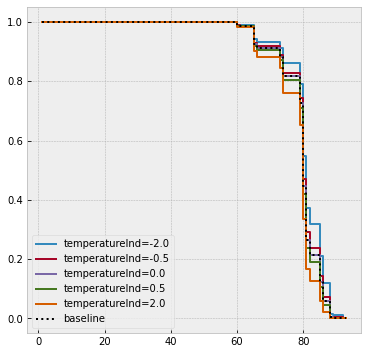

In [23]:
plt.figure(figsize=(6,6))

model_cph.plot_partial_effects_on_outcome("temperatureInd", [-2, -0.5, 0, 0.5, 2], ax=plt.gca())

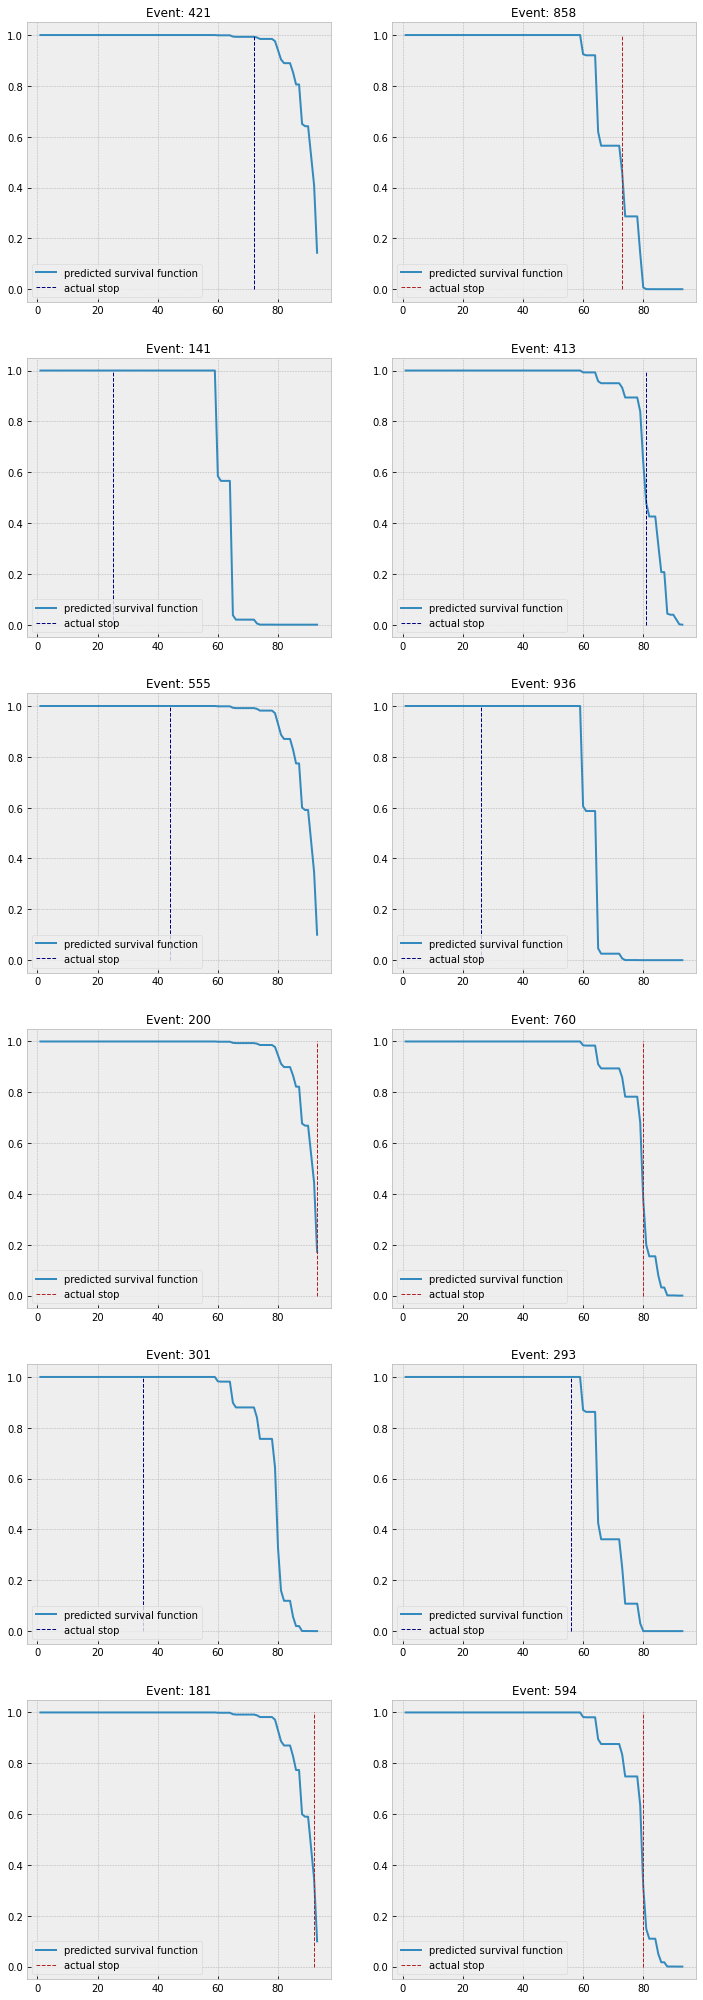

In [25]:
plt.figure(figsize=(12, 36))

for pi, (ri, row) in enumerate(features.sample(12, random_state=8764).iterrows()):
    plt.subplot(6, 2, pi+1)
    model_cph.predict_survival_function(row).iloc[:, 0].rename("predicted survival function").plot(ax=plt.gca())

    plt.plot([row.lifetime, row.lifetime], [0, 1], "--", linewidth=1,
            c="firebrick" if row.broken==1 else "navy", label="actual stop")
    plt.legend(loc=3)
    plt.title(f"Event: {ri}", fontsize=12)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



/home/traveller/.local/lib/python3.8/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1000 total observations, 603 right-censored observations>
         test_name = proportional_hazard_test

---
                         test_statistic      p  -log2(p)
moistureInd        km              0.21   0.65      0.63
                   rank            0.44   0.51      0.98
pressureInd        km              0.07   0.79      0.34
                   rank            0.01   0.93      0.10
provider_Provider1 km              7.07   0.01      6.99
                   rank            8.90 <0.005      8.45
provider_Provider2 km              0.33   0.57      0.82
                   rank            0.27   0.60      0.74
provider_Provider3 km             40.92 <0.005     32.56
                   rank           41.95 <0.005     33.32
provider_Provider4 km             16.75 <0.005     14.52
                   rank           15.24 <0.005     13.36
team_TeamA         km              0.33   0.56      0.82
                   rank            0.07   0.80      0.33
team_TeamB         km              0.27   0.60      0.73
                   rank            0.04   0.83      0.26
team_TeamC         km              1.22   0.27      1.89
                   rank            0.22   0.64      0.65
temperatureInd     km              0.15   0.70      0.52
                   rank            0.08   0.78      0.36



1. Variable 'provider_Provider1' failed the non-proportional test: p-value is 0.0029.

   Advice: with so few unique values (only 2), you can include `strata=['provider_Provider1', ...]`
in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'provider_Provider3' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['provider_Provider3', ...]`
in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


3. Variable 'provider_Provider4' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['provider_Provider4', ...]`
in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%

[[<matplotlib.axes._subplots.AxesSubplot at 0x7f9b70add0a0>,

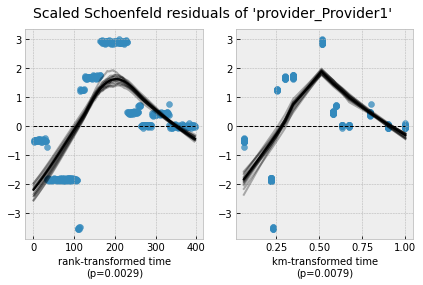

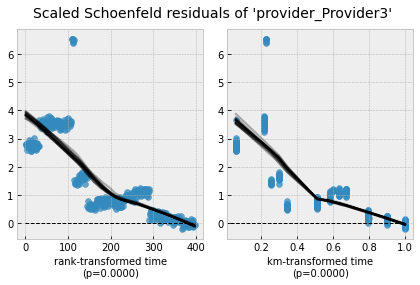

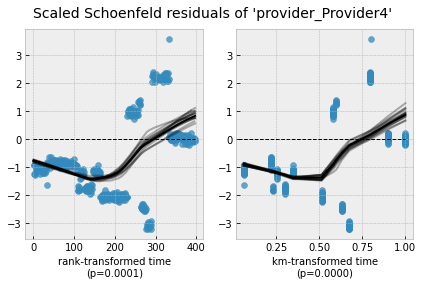

In [26]:
model_cph.check_assumptions(features, show_plots=True)

# Stratified model

In [27]:
NUM_FTS = ['pressureInd', 'moistureInd', 'temperatureInd']

sfeatures = orig_features.copy()
sfeatures[NUM_FTS] = (features[NUM_FTS] - features[NUM_FTS].mean()) / features[NUM_FTS].std()

sfeatures = pd.get_dummies(sfeatures, columns=["team"])

In [28]:
model_cph = lifelines.CoxPHFitter(penalizer=0.1)
model_cph.fit(sfeatures, duration_col="lifetime", event_col="broken", strata="provider")

model_cph.print_summary()

model,lifelines.CoxPHFitter
duration col,'lifetime'
event col,'broken'
penalizer,0.1
l1 ratio,0.0
strata,provider
baseline estimation,breslow
number of observations,1000
number of events observed,397
partial log-likelihood,-1305.41
time fit was run,2021-03-08 12:55:09 UTC


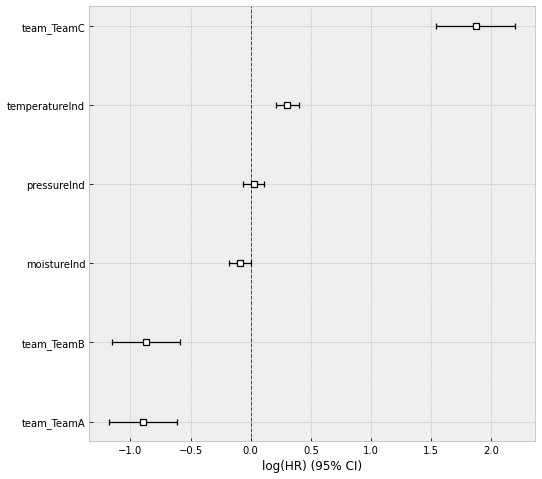

In [29]:
plt.figure(figsize=(8,8))
model_cph.plot()

In [30]:
model_cph.check_assumptions(sfeatures, show_plots=True)

Proportional hazard assumption looks okay.


/home/traveller/.local/lib/python3.8/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


[]

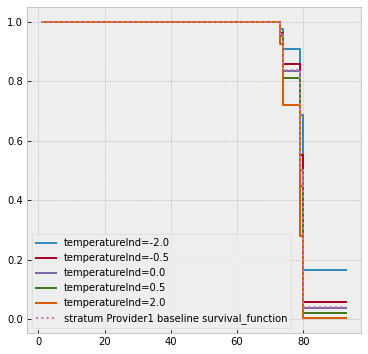

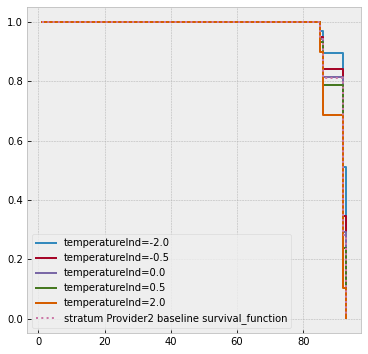

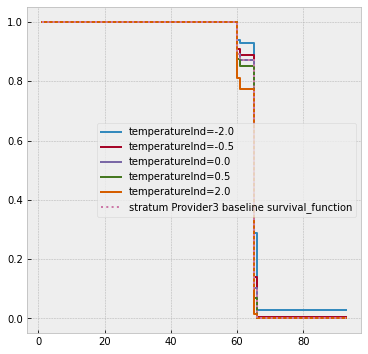

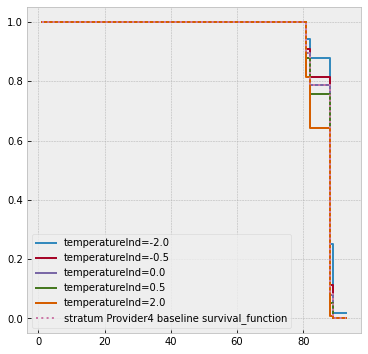

In [31]:
model_cph.plot_partial_effects_on_outcome("temperatureInd", [-2, -0.5, 0, 0.5, 2], figsize=(6,6));

In [ ]:
plt.figure(figsize=(12, 36))

for pi, (ri, row) in enumerate(sfeatures.sample(12, random_state=8764).iterrows()):
    plt.subplot(6, 2, pi+1)
    model_cph.predict_survival_function(row).iloc[:, 0].rename("predicted survival function").plot(ax=plt.gca())

    plt.plot([row.lifetime, row.lifetime], [0, 1], "--", linewidth=1,
            c="firebrick" if row.broken==1 else "navy", label="actual stop")
    plt.legend(loc=3)
    plt.title(f"Event: {ri}", fontsize=12)